# Score Matrix

Use model to generate confusion matrix



In [1]:
#import fnmatch
#import os
#import pathlib
#import random
#import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
#import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
#from tqdm import tqdm
from PIL import Image
from data_loader import (
    TRAIN_DIR,
    VALID_DIR,
    augment_and_save,
    data_distribution,
    imagenet_stats,
    img_transforms,
    plot_data_distribution,
    show_data,
)
sns.set_theme(style="whitegrid", palette="husl")

/home/u103128/.conda/envs/PT/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/u103128/.conda/envs/PT/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
2023-08-04 11:56:26,723 - numexpr.utils - INFO - Note: detected 224 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-08-04 11:56:26,724 - numexpr.utils - INFO - Note: NumExpr detected 224 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-08-04 11:56:26,724 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Device set to xpu by user.
OMP_NUM_THREADS set to: 112


# Specify Model to test

In [2]:
# simple = False
# epochs = 12
# ipx = True 
# dropout = .5
# batch_size = 128
# # bc_resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
# model_name = "ON_resnet18_simpleFalse_IPEXTrue_Epochs40_dropout0.33_batch128"
# #resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
# #model_name = f"resnet18_simple{simple}_IPEX{ipx}_Epochs{epochs}_dropout{dropout}_batch{batch_size}"
# print(model_name)
# model_read = torch.jit.load(f"models/{model_name}.pt")

# model_read.eval()

# Define Predict Function

In [3]:
def predict(InFldr, ScoreDict, model):
    import torchvision.transforms as transforms
    import torch.nn as nn
    import glob 
    model.eval()

    scores = []
    fns = []
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ])
    
    for fn in glob.glob(TEST_DIR+'*.png'):
        img = Image.open(fn)
        img_tensor = transform(img).reshape(1, 3, 1024, 1024)
        score = 0
        modelCPU = model.to("cpu")
        score = np.argmax(torch.softmax( modelCPU(img_tensor).detach(), dim =1).numpy().squeeze())
        fns.append(fn)
        scores.append(ScoreDict[score])
    return (scores, fns)
# model.eval()
# with torch.no_grad():
#     model_scripted = torch.jit.script(model.to("cpu"))  # Export to TorchScript
#     model_scripted.save(model_save_path)  # Jit Save

In [4]:
#model_save_path
model_name = f"models/model_acc_84_device_xpu_lr_0.000214_epochs_20_jit.pt"
print(model_name)

model_read = torch.jit.load(model_name)
#model_read.eval()

models/model_acc_84_device_xpu_lr_0.000214_epochs_20_jit.pt


# Scoring individual images with model
### Known Fire

In [5]:
ytrue = []
ypred = []
TEST_DIR =  'data/colorEnhanced/val/Fire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model_read)
for score, fn in zip(scores, fns):
    print(f"{score}\t{fn}")
    if score == 'Fire': 
        ypred.append(1)
    else:
        ypred.append(0)
    ytrue.append(1)

Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_3.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_late_afternoon_with_signs_of_wild_fire,_no_clouds_1.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_late_afternoon_with_signs_of_wild_fire,_no_clouds_16.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_6.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_late_afternoon_with_signs_of_wild_fire,_no_clouds_4.png
NoFire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_9.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_15.png
NoFire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_2.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_signs_of_wild_fire_11.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_

# Scoring individual images with model
### Known NoFire

# Define functions and normalization parameters

In [6]:
TEST_DIR =  'data/colorEnhanced/val/NoFire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model_read)
for score, fn in zip(scores, fns):
    print(f"{score}\t{fn}")
    if score == 'Fire': 
        ypred.append(1)
    else:
        ypred.append(0)
    ytrue.append(0)

NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_mid-day_with_clear_skies_with_no_signs_of_wild_fire_2.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_early_morning_with_clear_skies_with_no_signs_of_wild_fire_15.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_mid-day_with_clear_skies_4.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_dense_vegetation_without_any_signs_of_a_wild_fire_8.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_early_morning_with_clear_skies_with_no_signs_of_wild_fire_5.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_no_signs_of_fire_1.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_mid-day_with_clear_skies_with_no_signs_of_wild_fire_12.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_sparse_vegetation_no_signs_of_wild_fire_9.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_sparse_vegetation_no_s

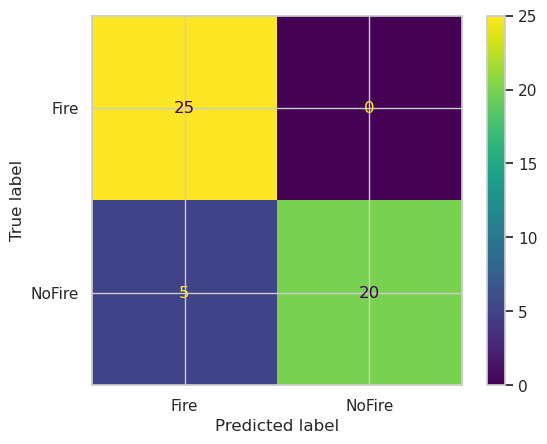

In [7]:
%matplotlib inline
fireDict = {0:'Fire', 1:'NoFire'}
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
YTRUE = [fireDict[val] for val in ytrue]
YPRED = [fireDict[val] for val in ypred]
labels=['Fire', 'NoFire']
cm = confusion_matrix(YTRUE, YPRED,  labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.show()

## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 